### Doc2Vec

Doc2vec is an adaptation of Word2Vec that allows us to learn document similarity. Doc2vec model by itself is an unsupervised method.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

c:\users\ariel.novelli\anaconda3\envs\env\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
columns = ['Pregunta', 'Intencion']
df_train = pd.read_csv('data/train.csv', usecols=columns, sep='|')
df_test = pd.read_csv('data/test_santander.csv', usecols=['id','Pregunta'])
df_train.head(10)

df_train['Intencion'] = df_train['Intencion'].str[4:]
df_train['Intencion'] = df_train['Intencion'].astype('int32')
#df_train['Intencion_encoded'] = labelEncoder(df_train, 'Intencion')
#df_train['Pregunta_encoded'] = labelEncoder(df_train, 'Pregunta')
#print('Train Shape: ' + str(df_train.shape))
#print('Test Shape: ' + str(df_test.shape))

In [3]:
df_train.shape

(20104, 2)

In [4]:
df_train.isnull().sum()

Pregunta     0
Intencion    0
dtype: int64

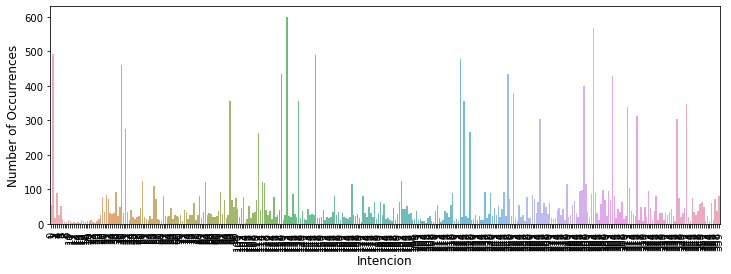

In [5]:
cnt_pro = df_train['Intencion'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Intencion', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [6]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [7]:
df_train['Pregunta'] = df_train['Pregunta'].apply(cleanText)
df_test['Pregunta'] = df_test['Pregunta'].apply(cleanText)

In [8]:
df_train['Pregunta'][1]

'pagar tarjeta visa querer reintegro'

In [9]:
df_train.shape

(20104, 2)

Re-arrange the index of the table. 

In [10]:
df_train.index = range(20104)

In [11]:
df_train.head(10)

,Pregunta,Intencion
0,como puedo trabajar en santander rio,102
1,pagar tarjeta visa querer reintegro,350
2,pagar tarjeta naranja sistema,132
3,no se debitó la primera cuota del plan de bien...,129
4,abonar tarjeta credito,342
5,se puede pagar la mastercard desde uno de los ...,342
6,informar que vamos a viajar al eterior,304
7,pasar preguntar seguridad,1
8,olvide mi contraseña de hombamnkin,1
9,como doy de baja la tarjeta por telefono no es...,338


In [12]:
df_test

,id,Pregunta
0,0,querer saber tarjeta sin limite
1,1,¿cuál es el límite de mi tarjeta santander?
2,2,hay beneficios en restaurantes de la costa atl...
3,3,semana realizar pagar afip monotributo volver ...
4,4,por un prestamo de mil. cuanto es el interes?
...,...,...
6697,6697,denunciar un cobro de tarjeta de credito
6698,6698,quiero pagar deuda refinanciada
6699,6699,quiero pagar de mi open credit un poquito mas ...
6700,6700,nesecito imprimir mi resumen tarjeta de credit...


In [13]:
df_train.rename(columns = {'Pregunta':'narrative'}, inplace = True)
df_test.rename(columns = {'Pregunta':'narrative'}, inplace = True)


In [14]:
df_train.head()

,narrative,Intencion
0,como puedo trabajar en santander rio,102
1,pagar tarjeta visa querer reintegro,350
2,pagar tarjeta naranja sistema,132
3,no se debitó la primera cuota del plan de bien...,129
4,abonar tarjeta credito,342


Below, we define a function to label each complaint narrative. And the TaggedDocument is an object-type to encapsulate a text-example function that helps to associate a tag/number with each document of the training corpus. In our case, the tag is simply the zero based line number.

In [15]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_train.narrative, df_train.Intencion, random_state=0, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [17]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_test.narrative, df_test.id, random_state=0, test_size=0.2)
X_train2 = label_sentences(X_train2, 'Train')
X_test2 = label_sentences(X_test2, 'Test')
all_data2 = X_train2 + X_test2

In [18]:
len(all_data)

20104

Let's take a look at the training corpus.

In [19]:
all_data[:2]

[TaggedDocument(words=['como', 'utilizar', 'autoservicio'], tags=['Train_0']),
 TaggedDocument(words=['necesito', 'hacer', 'una', 'certificacion', 'de', 'mi', 'firma'], tags=['Train_1'])]

In [20]:
all_data2[:2]

[TaggedDocument(words=['hacer', 'una', 'simulación', 'de', 'préstamo'], tags=['Train_0']),
 TaggedDocument(words=['necesito', 'descargar', 'la', 'boleta', 'de', 'la', 'tarjeta', 'santander'], tags=['Train_1'])]

### Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

dm =0 means ‘distributed bag of words’ (DBOW), set min_count=2 means ignoring all words with total frequency lower than this, size=100 is dimensionality of the generated feature vectors, alpha=0.025 is the initial alpha rate, learning rate will linearly drop to min_alpha as training progresses. And then we build a vocabulary.

In [21]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
#model_dbow.build_vocab([x for x in tqdm(all_data)])
model_dbow.build_vocab([x for x in tqdm(all_data+all_data2)])


100%|███████████████████████████████████████████████████████████████████████| 26806/26806 [00:00<00:00, 1559396.85it/s]


In [22]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    #model_dbow.train(utils.shuffle([x for x in tqdm(all_data+all_data2)]), total_examples=len(all_data+all_data2), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 20104/20104 [00:00<00:00, 2879761.20it/s]


Wall time: 16.3 s


Define a function to get the vectors.

In [25]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [26]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [27]:
#from sklearn.linear_model import LogisticRegression

#logreg = LogisticRegression(multi_class='multinomial', max_iter=100)
#logreg.fit(train_vectors_dbow, y_train)
#logreg.score(test_vectors_dbow, y_test)


In [28]:
from sklearn.svm import LinearSVC, SVC

svc_1 = SVC(C=100, gamma=0.1, kernel="rbf")
#svc_1 = LinearSVC(C=1)

svc_1.fit(train_vectors_dbow, y_train)
svc_1.score(test_vectors_dbow, y_test)
#svc_1.score(train_vectors_dbow, y_train)



0.6550609301168864

In [30]:
model_dbow.save('d2v_model_dbow.doc2vec')

### Distributed Memory

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

We again instantiate a Doc2Vec model with a vector size with 100 words and iterating over the training corpus 30 times.

In [31]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data+all_data2)])

100%|███████████████████████████████████████████████████████████████████████| 26806/26806 [00:00<00:00, 2687522.72it/s]


In [32]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|███████████████████████████████████████████████████████████████████████| 20104/20104 [00:00<00:00, 2523410.57it/s]


Wall time: 33.9 s


In [33]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [34]:
#logreg.fit(train_vectors_dm, y_train)
svc_1.fit(train_vectors_dm, y_train)
svc_1.score(test_vectors_dm, y_test)

0.43148470529718974

In [35]:
model_dm.save('d2v_model_dm.doc2vec')

In [36]:
# model_dbow = Doc2Vec.load('d2v_model_dbow.doc2vec')
# model_dm = Doc2Vec.load('d2v_model_dm.doc2vec')
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [37]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [38]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

In [39]:
%%time
svc_1 = SVC(C=100, gamma=0.1, kernel="rbf")
svc_1.fit(train_vecs_dbow_dm, y_train)
#logreg = LogisticRegression()
#logreg.fit(train_vecs_dbow_dm, y_train)

Wall time: 4min 43s


SVC(C=100, gamma=0.1)

In [41]:
svc_1.score(test_vecs_dbow_dm, y_test)

0.6272071623974136